# Examples Using a Water Molecule

This is a basic example workflow where we will perform some calculations with **AMS2020.1**. The examples are similar to the official documentation, but have some additional documentation available.

## 0. Setting up the environment

First of all, we need to assure that we use the ams python shell. this can be assured in Jupyter lab by looking on the upperright corner, where we see 'AMS2020.1.venv'. When using a script, the relevant python-shell can be set by starting the script with a shebang (assure that AMS is loaded or installed).
```python
#!/usr/bin/env amspython
```
or
```python
#~/ams2021.202.r94433/bin/amspython
```
First of all,
We import all functions from plams and params using the first 2 lines of code.

On top, we import 
* ```numpy```. This is a numerical python library that includes highly-efficient array operations.
* ```matplotlib```. Popular plotting library

Once all libraries are imported, we assign a few paths to the relevant files. 
```ffield``` points to the water force field, ```geo``` to the geo file, *etc...*.
These will be used later on.

In [143]:
from scm.plams import *
from scm.params import *

import numpy as np
import matplotlib.pyplot as plt

In [144]:
# Assigning the different (full) paths to the relevant files
ffield = '/work/dumortil/Documents/software/params_runscript_examples/data/Water2017.ff'
geo = '/work/dumortil/Documents/software/params_runscript_examples/data/geo'
trainingset = '/work/dumortil/Documents/software/params_runscript_examples/data/trainset.in'
xyz = '/work/dumortil/Documents/software/params_runscript_examples/data/water.xyz'

## 1. Geometry Optimization
In the next part, we will focus on Geometry Optimization

### 1.1 Compatible with old interface

In [57]:
# Defining the settings for the geometry optimization
s = Settings()
s.input.ams.Task = 'GeometryOptimization'
s.input.ams.GeometryOptimization.Method = 'FIRE'
s.input.ams.GeometryOptimization.MaxIterations = 1000
s.input.reaxff.ForceField = ffield

In [58]:
# Here we read in the geo file. It automatically extracts some settings. Extra settings can be provided 
# by the normal_run_settings.
# If you want to edit the settings, you must do this afterwards.
jobcollection = geo_to_params(geo, normal_run_settings=Settings())
jobs = jobcollection.to_amsjobs()
jobs[0].settings = s

In [61]:
# starting the geometry optimization
# This first requires an init() and must be closed with the finish() command.
init()
jr = JobRunner(parallel=True, maxjobs=0)
jobs[0].run(jobrunner=jr)
finish()

[16:00:36] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.002
[16:00:36] JOB coordinates STARTED
[16:00:36] JOB coordinates RUNNING
[16:00:38] JOB coordinates FINISHED
[16:00:38] JOB coordinates SUCCESSFUL
[16:00:38] PLAMS run finished. Goodbye


### 1.3 From *.xyz* file
By reading in a xyz file instead, we can circumvent the conversion of the old reaxff interface. This approach is the most conventional way of working with plams and par

In [179]:
mol = Molecule(xyz)
print(mol)

  Atoms: 
    1         O      0.000000      0.000000      0.000000 
    2         H      0.758602      0.000000      0.504284 
    3         H      0.758602      0.000000     -0.504284 



In [180]:
# Add a small disturbance
mol.atoms[2].coords=(1.0,0.0,-0.4)

In [181]:
# Defining the settings for the geometry optimization
s = Settings()
s.input.ams.Task = 'GeometryOptimization'
s.input.ams.GeometryOptimization.Method = 'FIRE'
s.input.ams.GeometryOptimization.MaxIterations = 1000
s.input.reaxff.ForceField = ffield

In [182]:
# Building the job
job = AMSJob(molecule=mol, settings=s)

In [183]:
init()
results = job.run()
finish()

[21:11:44] JOB plamsjob STARTED
[21:11:44] JOB plamsjob RUNNING
[21:11:45] JOB plamsjob FINISHED
[21:11:45] JOB plamsjob SUCCESSFUL
[21:11:45] PLAMS run finished. Goodbye


### 1.2 From scratch
Here we will build up the molecule from scratch and build the job that needs to be run. Such an approach can be useful for generating small molecules, exotic molecules, highly symmetric molecules (exploit loops) and/or manually adding disturbances.

In [184]:
mol = Molecule()
mol.add_atom(Atom(symbol='O', coords=(0.00,0.00,0.00)))
mol.add_atom(Atom(symbol='H', coords=(1.00,0.00,1)))
mol.add_atom(Atom(symbol='H', coords=(0.00,1.00,-1)))


In [185]:
# Defining the settings for the geometry optimization
s = Settings()
s.input.ams.Task = 'GeometryOptimization'
s.input.ams.GeometryOptimization.Method = 'FIRE'
s.input.ams.GeometryOptimization.MaxIterations = 1000
s.input.reaxff.ForceField = ffield

In [187]:
print(mol)

  Atoms: 
    1         O      0.000000      0.000000      0.000000 
    2         H      1.000000      0.000000      1.000000 
    3         H      0.000000      1.000000     -1.000000 



In [173]:
# Building the job
job = AMSJob(molecule=mol, settings=s)

In [174]:
init()
results = job.run()
finish()

[21:10:16] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.006
[21:10:16] JOB plamsjob STARTED
[21:10:16] JOB plamsjob RUNNING
[21:10:18] JOB plamsjob FINISHED
[21:10:18] JOB plamsjob SUCCESSFUL
[21:10:18] PLAMS run finished. Goodbye


In [175]:
# We can extract properties within the same script that we obtained immediately
endmolecule = results.get_main_molecule()
print(endmolecule)

  Atoms: 
    1         O      0.054998      0.054998      0.000000 
    2         H      0.776520      0.168482      0.608039 
    3         H      0.168482      0.776521     -0.608039 



## 2. Multiple parallel singlepoint calculations with a LennardJones potential
This can be handy when DFT-code is available. For now, we use a simple LennardJones potential


In [134]:
# Define the jobrunner, and set the parallel option to True
config.default_jobrunner = JobRunner(parallel=True)

In [188]:
# Defining the settings for Single Point Lennard Jones
s = Settings()
s.input.ams.Task = 'Singlepoint'
s.input.LennardJones.Cutoff = 10

In [189]:
print(s)

input: 	
      ams: 	
          Task: 	Singlepoint
      LennardJones: 	
                   Cutoff: 	10



In [233]:
# Build multiple 'molecules' of H-H with different distances between each other
# This can be conveniently done using a for-loop in python

# first, we create an empty list 'jobs' to store all the job specifications (i.e. a singlepoint calculation)
# These can then later be launched
Jobs = []

# Here we build up the Jobs. We start by generating a molecule in each loop, setting one H-atom at the center, 
# then one at a distance d in one direction. We set d from 0.5 till 4.1 with 0.1 intervals
for d in np.arange(0.9, 2, 0.05):
    print('Setting up molecule with distance {:3f}'.format(d))
    mol = Molecule()
    atom1 = Atom(symbol='H', coords=(0,0,0))
    atom2 = Atom(symbol='H', coords=(d,0,0))
    mol.add_atom(atom1)
    mol.add_atom(atom2)
    job = AMSJob(molecule=mol, settings=s)
    Jobs.append(job)

Setting up molecule with distance 0.900000
Setting up molecule with distance 0.950000
Setting up molecule with distance 1.000000
Setting up molecule with distance 1.050000
Setting up molecule with distance 1.100000
Setting up molecule with distance 1.150000
Setting up molecule with distance 1.200000
Setting up molecule with distance 1.250000
Setting up molecule with distance 1.300000
Setting up molecule with distance 1.350000
Setting up molecule with distance 1.400000
Setting up molecule with distance 1.450000
Setting up molecule with distance 1.500000
Setting up molecule with distance 1.550000
Setting up molecule with distance 1.600000
Setting up molecule with distance 1.650000
Setting up molecule with distance 1.700000
Setting up molecule with distance 1.750000
Setting up molecule with distance 1.800000
Setting up molecule with distance 1.850000
Setting up molecule with distance 1.900000
Setting up molecule with distance 1.950000


In [234]:
# Now we can start all the jobs in parallel. We will store the results as well
results=[]

init()
for job in Jobs:
    results.append(job.run())
finish()

[14:52:50] PLAMS working folder: /work/dumortil/Documents/software/params_runscript_examples/examples/plams_workdir.003
[14:52:50] JOB plamsjob STARTED
[14:52:50] JOB plamsjob RUNNING
[14:52:51] JOB plamsjob FINISHED
[14:52:51] JOB plamsjob SUCCESSFUL
[14:52:51] JOB plamsjob STARTED
[14:52:51] Renaming job plamsjob to plamsjob.002
[14:52:51] JOB plamsjob.002 RUNNING
[14:52:52] JOB plamsjob.002 FINISHED
[14:52:52] JOB plamsjob.002 SUCCESSFUL
[14:52:52] JOB plamsjob STARTED
[14:52:52] Renaming job plamsjob to plamsjob.003
[14:52:52] JOB plamsjob.003 RUNNING
[14:52:53] JOB plamsjob.003 FINISHED
[14:52:53] JOB plamsjob.003 SUCCESSFUL
[14:52:53] JOB plamsjob STARTED
[14:52:53] Renaming job plamsjob to plamsjob.004
[14:52:53] JOB plamsjob.004 RUNNING
[14:52:54] JOB plamsjob.004 FINISHED
[14:52:54] JOB plamsjob.004 SUCCESSFUL
[14:52:54] JOB plamsjob STARTED
[14:52:54] Renaming job plamsjob to plamsjob.005
[14:52:54] JOB plamsjob.005 RUNNING
[14:52:55] JOB plamsjob.005 FINISHED
[14:52:55] JOB 

In [235]:
# Extracting the information a nice graph of the energy in function of the distances
distances = []
energies = []
for res in results:
    energies.append(res.get_energy())
    mol = res.get_main_molecule()
    distance = mol.atoms[1].coords[0] - mol.atoms[0].coords[0]
    distances.append(distance)

In [237]:
print('Distances: {}'.format(distances))
print('Energies: {}'.format(energies))

Distances: [0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.4999999999999998, 1.5499999999999998, 1.5999999999999999, 1.6499999999999997, 1.6999999999999997, 1.7499999999999998, 1.8, 1.85, 1.9, 1.95]
Energies: [-0.2226466848456905, -0.8701304777779026, -1.0, -0.9355933750956956, -0.8103170423971975, -0.677748041636447, -0.5576392985761532, -0.4555685232639998, -0.37143043964801503, -0.30310092364047014, -0.2479820391814439, -0.20361327029731185, -0.16787564376854638, -0.13902455901407265, -0.11565657587198075, -0.09665622248158585, -0.08114200759789528, -0.06841873723504421, -0.05793795800851312, -0.04926619244136731, -0.0420598809496469, -0.03604580407595111]


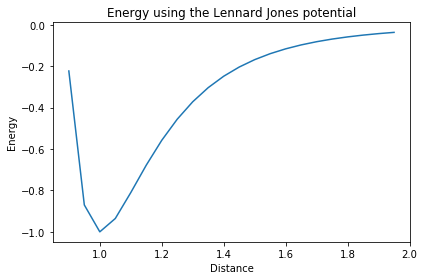

In [238]:
fig, ax = plt.subplots()
ax.plot(distances, energies)
ax.set_title('Energy using the Lennard Jones potential')
ax.set_xlabel('Distance')
ax.set_ylabel('Energy')

plt.tight_layout()
plt.show()